In [179]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [31]:
BASE_PATH = 'data/'
annual_cases = pd.read_csv(BASE_PATH + 'contraceptive_case_data_annual.csv')
train = pd.read_csv(BASE_PATH + 'Train.csv')
product = pd.read_csv(BASE_PATH + 'product.csv')
monthly_cases = pd.read_csv(BASE_PATH + 'monthly_cases.csv')
site_df = pd.read_csv(BASE_PATH + 'service_delivery_site_data.csv')
ss = pd.read_csv(BASE_PATH + 'SampleSubmission.csv')

In [32]:
train.head()

,year,month,region,district,site_code,product_code,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered
0,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27134,75,0,21,-54,0,18,0,100.0
1,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27132,3,0,3,0,0,2,0,10.0
2,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27000,0,75,22,0,53,9,0,0.0
3,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27137,2,0,0,0,2,0,0,0.0
4,2019,1,INDENIE-DJUABLIN,ABENGOUROU,C4001,AS27138,45,0,2,0,43,1,0,0.0


### Making a datetime variable

In [33]:
train['date'] = pd.to_datetime(train['year'].astype(str)  + train['month'].astype(str), format='%Y%m')

### Grouping to get overall time trend aggregates

In [34]:
train_by_month_year = train.groupby(['date']).sum().reset_index().drop(['month', 'year'], axis = 1)

In [63]:
train_by_month_year.set_index(train_by_month_year['date'], inplace = True)

In [64]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Aggregated Stock Distribution for {}".format(name))

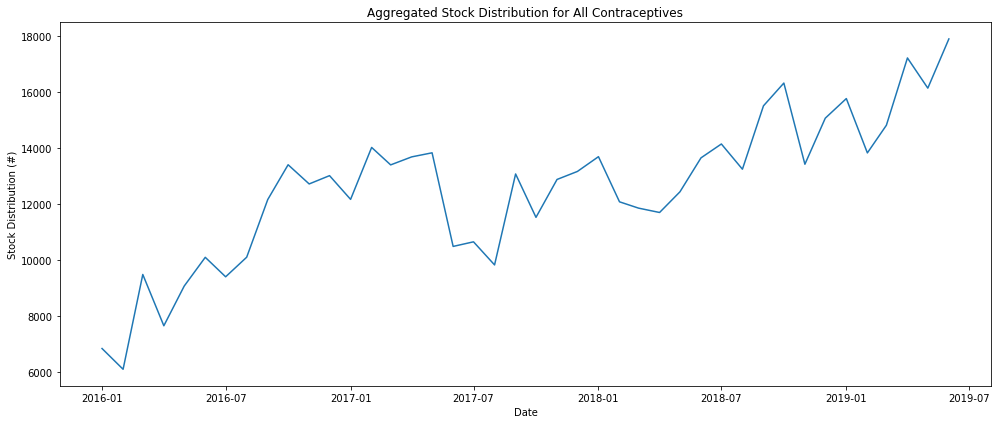

In [65]:
fig, ax = plt.subplots(1, figsize=(14, 6))
plot_trend_data(ax, 'All Contraceptives', train_by_month_year['stock_distributed'])
# ax.set_title('Aggregated Stock Distribution from 01/2016 - 06/2019')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Distribution (#)')

plt.tight_layout()

### Let's check by contraceptive aggregated over all sites

In [68]:
train_by_product = train.groupby(['date', 'product_code']).sum().reset_index().drop(['month', 'year'], axis = 1)

In [69]:
train_by_product.set_index(train_by_product['date'], inplace = True)

In [70]:
train_by_product_names = train_by_product['product_code'].to_list()

In [71]:
product_trends = {
    name: train_by_product[train_by_product['product_code']==name]
    for name in train_by_product_names
}

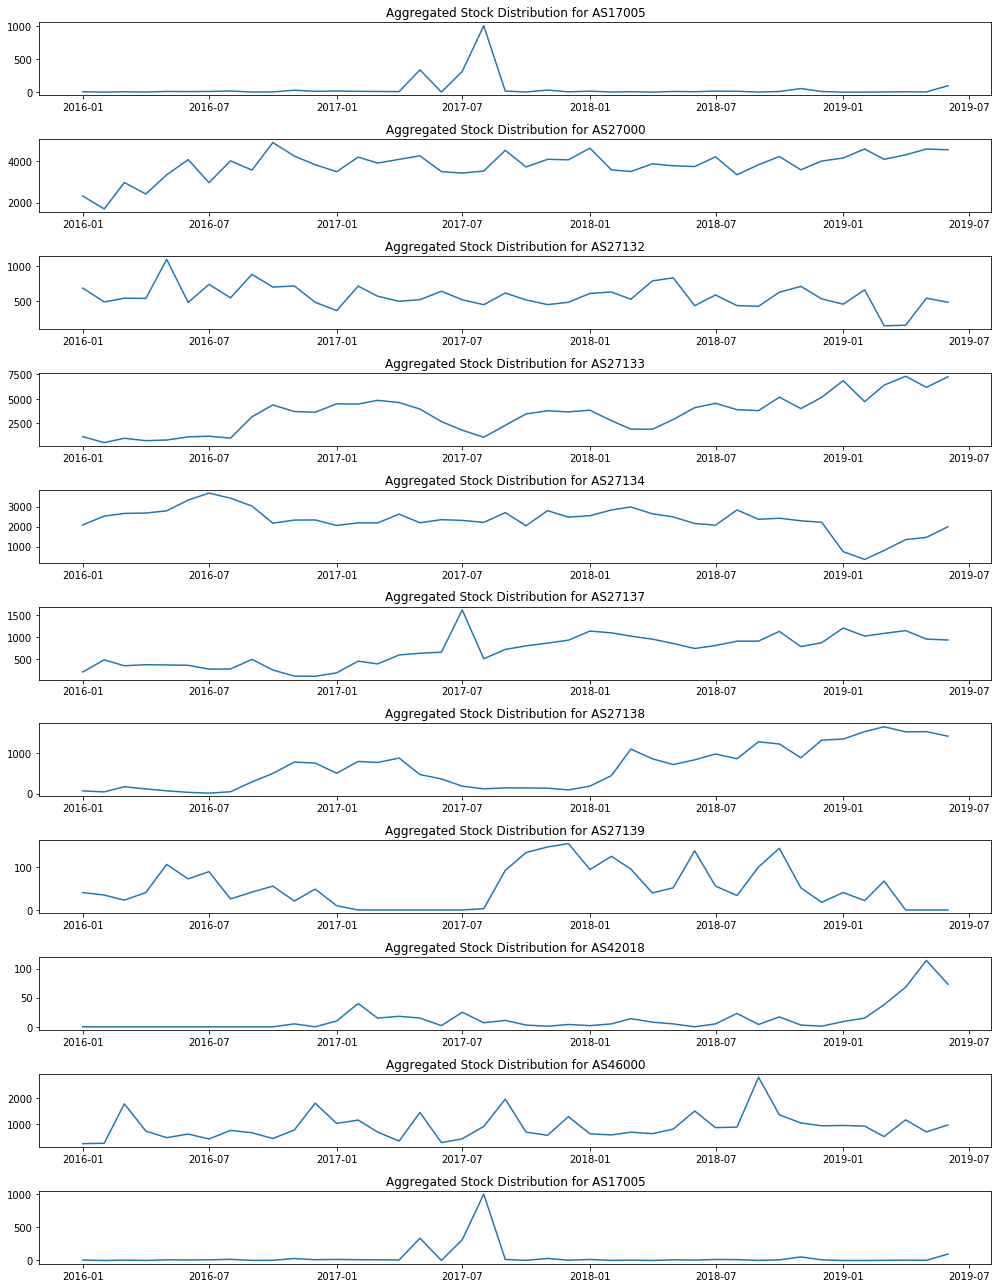

In [75]:
fig, axs = plt.subplots(len(product_trends), figsize=(14, 18))

for ax, name in zip(axs, train_by_product_names):
    plot_trend_data(ax, name, train_by_product[train_by_product['product_code']==name]['stock_distributed'])
    
plt.tight_layout()

In [ ]:
def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

### All Contraceptives Linear Trend

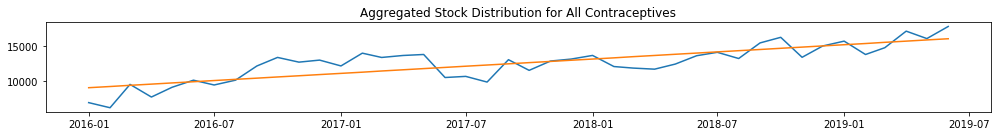

In [76]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_linear_trend(ax, 'All Contraceptives', train_by_month_year['stock_distributed'])
plt.tight_layout()

### All Contraceptives Detrended

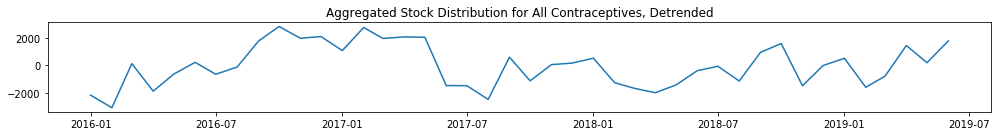

In [78]:
all_series = train_by_month_year['stock_distributed']
all_linear_trend = fit_linear_trend(python_series)
all_series_detrended = all_series - all_linear_trend

fig, ax = plt.subplots(1, figsize=(14, 2))
ax.plot(python_series_detrended.index, python_series_detrended)
ax.set_title("Aggregated Stock Distribution for All Contraceptives, Detrended")
plt.tight_layout()

### Linear Trends by Product Code

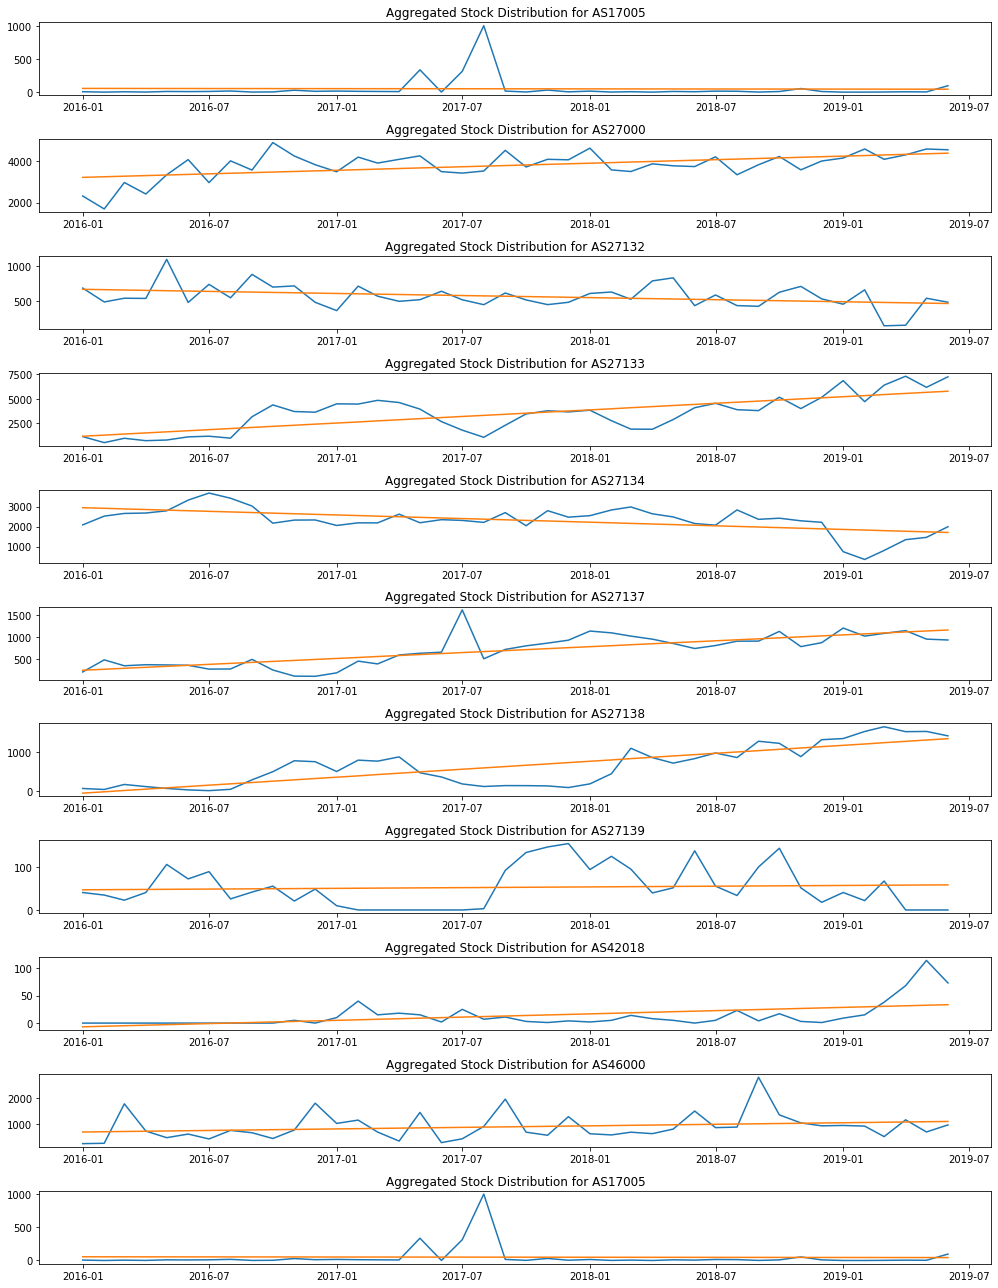

In [79]:
fig, axs = plt.subplots(len(product_trends), figsize=(14, 18))

for ax, name in zip(axs, train_by_product_names):
    plot_linear_trend(ax, name, train_by_product[train_by_product['product_code']==name]['stock_distributed'])
    
plt.tight_layout()

In [95]:
def fit_moving_average_trend(series, window=3):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=3):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

### Rolling Average for Aggregated stock for all contraceptives

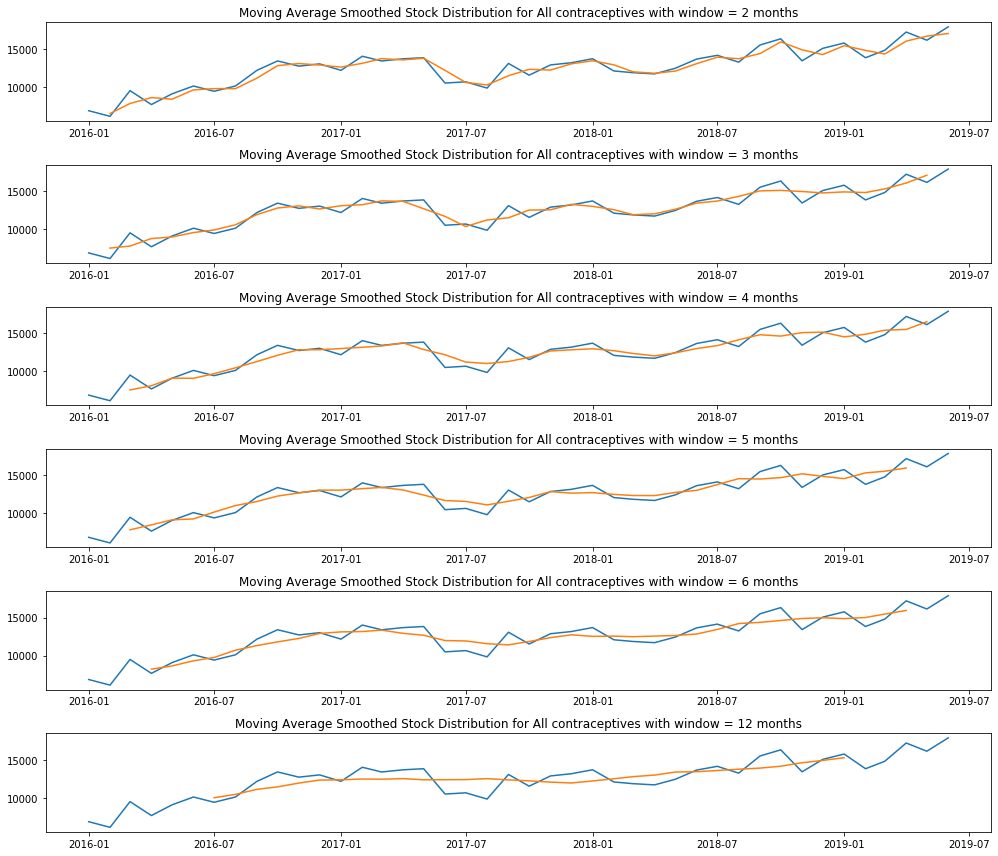

In [101]:
fig, axs = plt.subplots(6, figsize=(14, 12))

stock_series = train_by_month_year['stock_distributed']
for i, window in enumerate([2, 3, 4, 5, 6, 12]):
    axs[i].plot(stock_series.index, stock_series)
    axs[i].plot(stock_series.index, fit_moving_average_trend(stock_series, window=window))
    axs[i].set_title("Moving Average Smoothed Stock Distribution for All contraceptives with window = {} months".format(window))
    
plt.tight_layout()

### Rolling average by product code

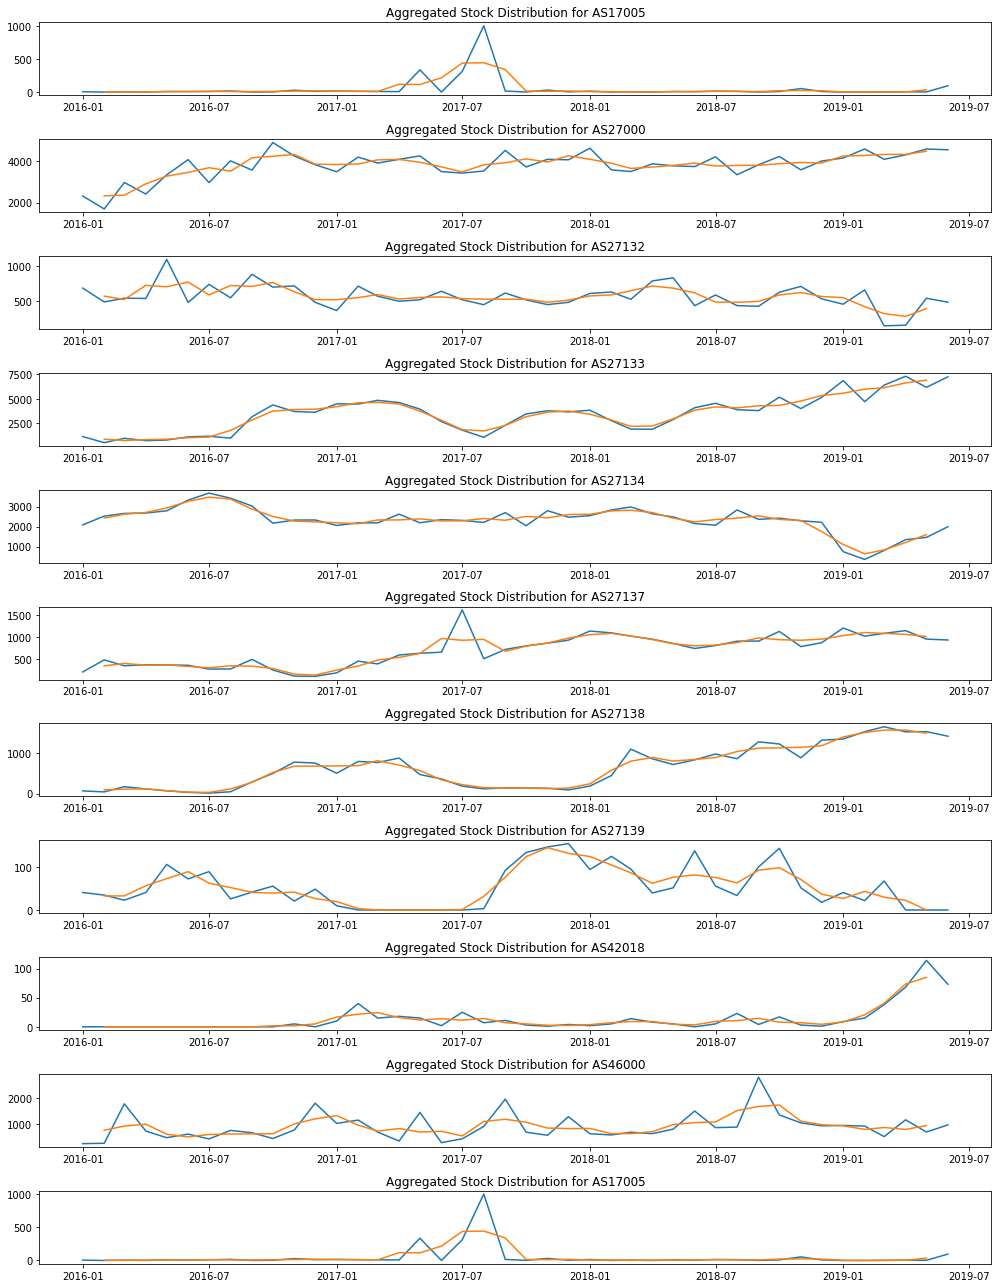

In [97]:
fig, axs = plt.subplots(len(product_trends), figsize=(14, 18))

for ax, name in zip(axs, train_by_product_names):
    plot_moving_average_trend(ax, name, train_by_product[train_by_product['product_code']==name]['stock_distributed'])
    
plt.tight_layout()

Overall, it didn't seem like we had general seasonal trends across each of the product codes aggregated across all sites

### Decomposition of all contraceptives

In [103]:
all_decomposition = sm.tsa.seasonal_decompose(train_by_month_year['stock_distributed'])


In [104]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

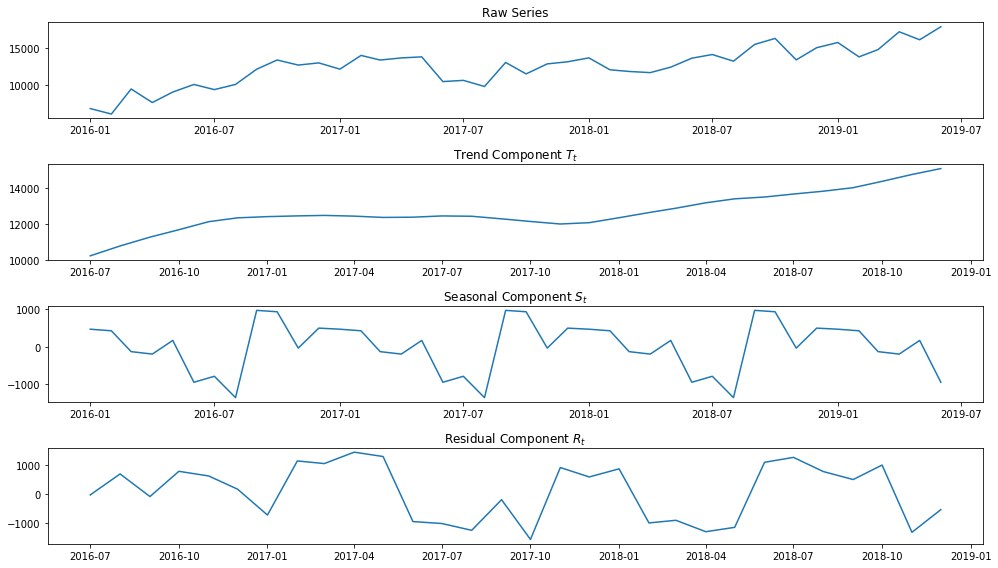

In [105]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, train_by_month_year['stock_distributed'], all_decomposition)
plt.tight_layout()

### Implementing ARIMA

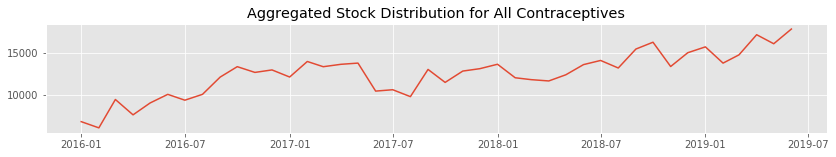

In [166]:
fig, ax = plt.subplots(1, figsize=(14, 2))
plot_trend_data(ax, 'All Contraceptives', train_by_month_year['stock_distributed'])

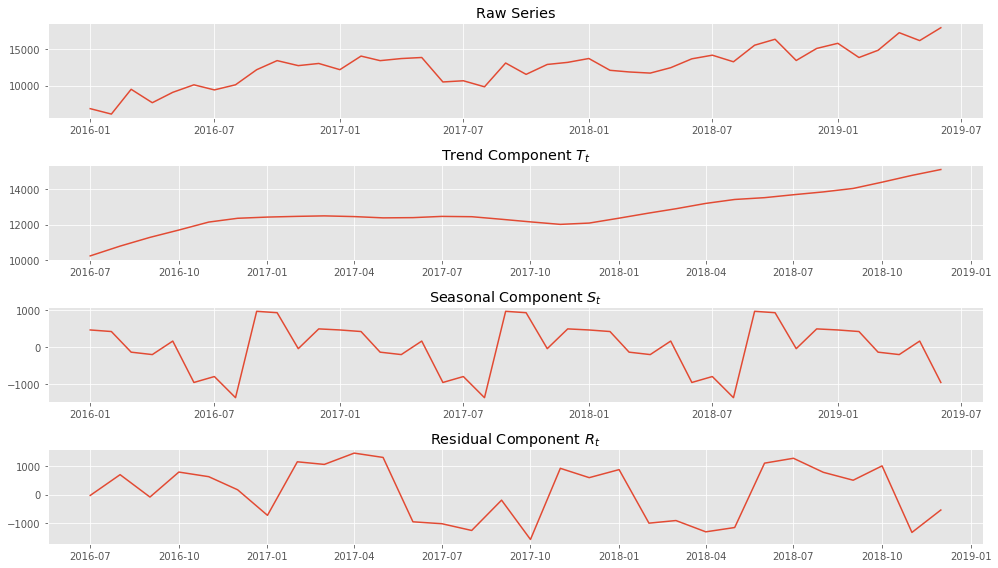

In [169]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, train_by_month_year['stock_distributed'], all_decomposition)
plt.tight_layout()


### Test for Stationarity

The Augmented Dickey-Fuller test is setup as follows:

$H_0$: The series is not-stationary.

$H_{\text{a}}$: The series is stationary.

In [171]:
test = sm.tsa.stattools.adfuller(train_by_month_year['stock_distributed'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.28


It is **not** stationary.


### Differencing
Most series encountered in nature are not stationary, but there is often a simple way (other than finding a fit) to transform one to be stationary.

In [173]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

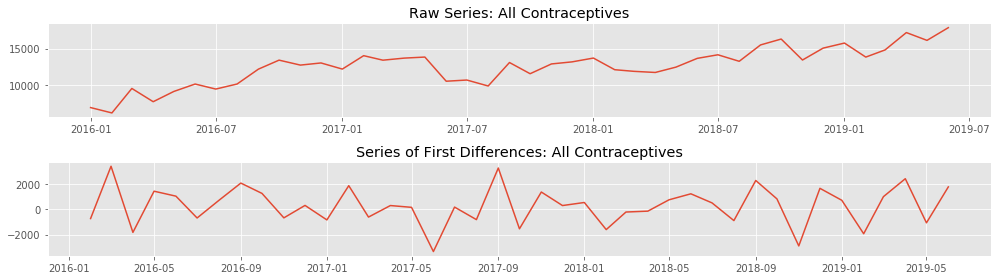

In [174]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, train_by_month_year['stock_distributed'], 'All Contraceptives')
fig.tight_layout()

The mean is zero, and the variance is more or less the same. There still may be some seasonality around the holidays, but let's see what the ADF test says.


In [175]:
yt = train_by_month_year['stock_distributed'].diff()[1:]  # the 0th value is NAN
test = sm.tsa.stattools.adfuller(yt)
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.00


### Identify p and q


In [177]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]  # note it's just the correlation coefficient

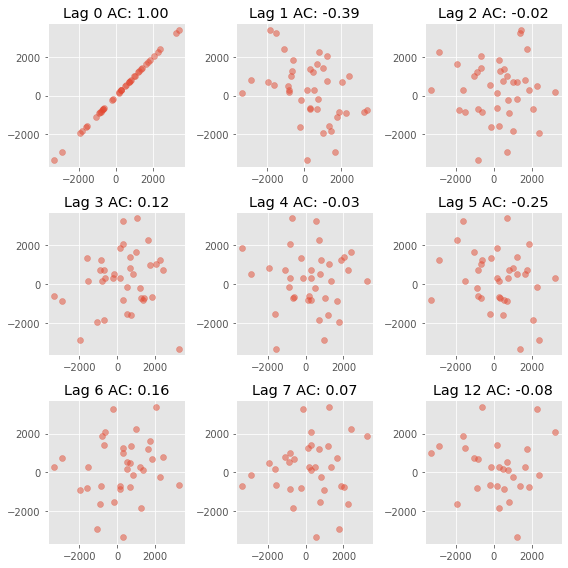

In [181]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

lags = [0,1,2,3,4,5,6,7,12]

for i, ax in zip(lags,axs.flatten()):
    series, lagged = series_and_lagged(yt, lag=i)
    autocorr = compute_autocorrelation(yt, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

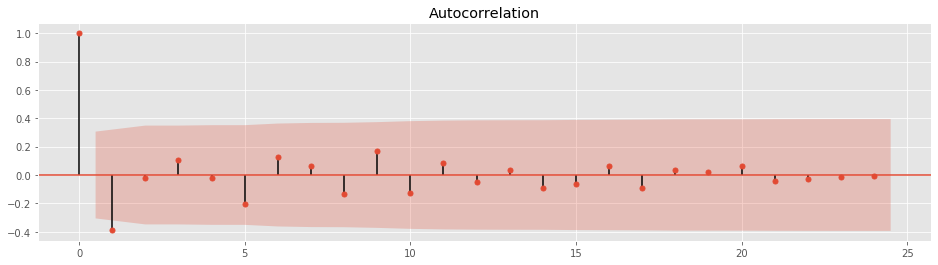

In [183]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(yt, lags=2*12, ax=ax)

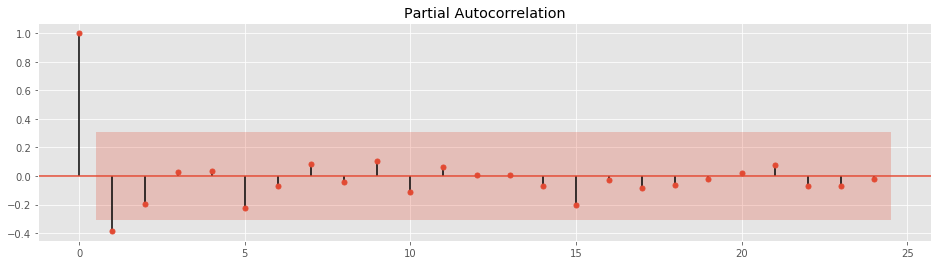

In [185]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(yt, lags=2*12, ax=ax, method='ywmle')

### Fit the model and coefficients

In [194]:
p = 1
d = 1
q = 0
model = ARIMA(train_by_month_year['stock_distributed'], order=(p, d, q)).fit()
model.params[1:]

ar.L1.D.stock_distributed   -0.388897
dtype: float64

In [291]:

trend2 = train_by_month_year['stock_distributed'].copy()
# trend2.index = pd.date_range(start='2016-01-01', end='2019-07-01', freq='M')
# fig, ax = plt.subplots(figsize=(12,6))
# ax = trend2.loc['2016-01-01':].plot(ax=ax)
# fig = model.plot_predict('2016', '2019-11-01', dynamic=True, ax=ax, plot_insample=False)
# plt.show()
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(trend2, order=(1, 1, 0), seasonal_order=(1, 0, 0, 12)).fit()
preds = model.predict('2019-06-01', '2020', 
                   dynamic=True, ax=ax, plot_insample=False)
preds

2019-06-01    16444.113722
2019-07-01    16330.613948
2019-08-01    16383.688282
2019-09-01    16319.614360
2019-10-01    16303.099403
2019-11-01    16371.780231
2019-12-01    16332.577939
2020-01-01    16315.673532
Freq: MS, dtype: float64

In [290]:
def MASE(y_train,y_test,y_hat):
  return (((y_train.shape[0]-1)/y_test.shape[0])*(np.sum(np.abs(y_test-y_hat))))/(np.sum(np.abs(y_train[1:]-y_train[0:-1])))

In [ ]:
MASE()

In [281]:
dta = trend2.copy()
dta.index = pd.date_range(start='2016-07-01', end='2020-01-01', freq='M')
res = sm.tsa.ARMA(dta, (2, 0)).fit()
# fig, ax = plt.subplots(figsize=(12,6))
# ax = dta.loc['2016':].plot(ax=ax)
# fig = res.plot_predict('2016', '2020', dynamic=True, ax=ax, plot_insample=False)
# plt.show()


In [206]:
index = train_by_month_year['stock_distributed'].index

In [232]:
df_train = train_by_month_year['stock_distributed'].iloc[:37]
df_test = train_by_month_year['stock_distributed'].iloc[37:]


In [233]:
mod_train = sm.tsa.AR(df_train)
res_train = mod_train.fit(max_lag=3, trend="nc")
print("Lag: %d" % res_train.k_ar)
print("Coeffs: %s" % res_train.params)

Lag: 9
Coeffs: L1.stock_distributed    0.655242
L2.stock_distributed    0.225659
L3.stock_distributed   -0.110499
L4.stock_distributed    0.232956
L5.stock_distributed   -0.149902
L6.stock_distributed   -0.026621
L7.stock_distributed    0.322314
L8.stock_distributed   -0.154146
L9.stock_distributed    0.027124
dtype: float64


In [282]:
res_train.predict(start=df_test.index[0], end='2019-11-01', dynamic=False)


2019-02-01    16171.478433
2019-03-01    15218.175188
2019-04-01    16283.087674
2019-05-01    16604.437335
2019-06-01    16106.744122
2019-07-01    16433.684916
2019-08-01    16774.063951
2019-09-01    17131.595711
2019-10-01    16864.387669
2019-11-01    17375.576674
Freq: MS, dtype: float64

In [235]:
df_test

date
2019-02-01    13834
2019-03-01    14821
2019-04-01    17223
2019-05-01    16145
2019-06-01    17902
Name: stock_distributed, dtype: int64

In [261]:
def resample_series(series, interval):
    df = series.resample(interval).sum()
    df = df.iloc[1:, :]
    df = df.drop('stock_distributed', axis = 1)
    return df
def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

In [262]:
series = train_by_month_year


In [263]:

series = resample_series(train_by_month_year, 'M')
d = series[:-2]

X = make_design_matrix(np.arange(len(d)) + 1)
linear_trend_ols = sm.OLS(d.values, X).fit()

In [265]:
slope_intercept = linear_trend_ols.params
slope = slope_intercept[0]
intercept = slope_intercept[1]

In [272]:
X

array([[ 1.,  1.],
       [ 2.,  1.],
       [ 3.,  1.],
       [ 4.,  1.],
       [ 5.,  1.],
       [ 6.,  1.],
       [ 7.,  1.],
       [ 8.,  1.],
       [ 9.,  1.],
       [10.,  1.],
       [11.,  1.],
       [12.,  1.],
       [13.,  1.],
       [14.,  1.],
       [15.,  1.],
       [16.,  1.],
       [17.,  1.],
       [18.,  1.],
       [19.,  1.],
       [20.,  1.],
       [21.,  1.],
       [22.,  1.],
       [23.,  1.],
       [24.,  1.],
       [25.,  1.],
       [26.,  1.],
       [27.,  1.],
       [28.,  1.],
       [29.,  1.],
       [30.,  1.],
       [31.,  1.],
       [32.,  1.],
       [33.,  1.],
       [34.,  1.],
       [35.,  1.],
       [36.,  1.],
       [37.,  1.],
       [38.,  1.],
       [39.,  1.]])